# TextbookQA App

This demo will create a QA system for the example textbooks, [Health Science](https://drive.google.com/file/d/1hOf6wPNjeUvWflVIRwjbB7h-qMTMMp-G/view) or [Intro to Nutrition](https://www.oercommons.org/courses/an-introduction-to-nutrition-v1-0/view). Relevant resources can be found in the examples directory.

## Part 1: Setting up the Model

In [1]:
# model weights are reuired prior to running this demo
# set weights directory here
weights = "models/2.0/base"

In [2]:
#export
import os

In [3]:
os.chdir("../")

In [4]:
#export
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, PretrainedConfig
import sqlite3, os, pandas as pd
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import save_npz, load_npz
import pickle
from pathlib import Path
from src import AlbertForQuestionAnsweringMTL, Config
from src.utils_app import get_pred, get_contexts, get_scores, bold_answer
import pandas as pd
import re
import json
import sys

In [5]:
#export
try:
    get_ipython
    example = "health_education" # default
    weights = weights
except:
    if len(sys.argv) < 2:
        raise ValueError("please provide the directory to the model weights as the first\
        argument in --args e.g. --args path/to/model/weights")
    elif len(sys.argv) < 3:
        weights = sys.argv[1]
        example = "health_education" # default
    elif len(sys.argv) == 3:
        weights = sys.argv[1]
        example = sys.argv[2]

config = Config(
    model = "albert-base-v2",
    pad_idx = 0,
    weights = weights,
    **json.load(open(f'examples/{example}/book-config.json',"r"))
)


In [6]:
config

{'model': 'albert-base-v2',
 'pad_idx': 0,
 'weights': 'models/2.0/base',
 'book_name': 'Health Education',
 'book_link': 'https://drive.google.com/file/d/1hOf6wPNjeUvWflVIRwjbB7h-qMTMMp-G/view',
 'sections_file_type': 'db',
 'sample_questions': ['',
  'What is health?',
  'How many calories should be consumed?',
  'What is cholesterol',
  'What are the types of carbohydrates?',
  'What are proteins?',
  'How many carbs should be had?',
  'What does the FDA regulate?',
  'What is ptsd?',
  'What causes ptsd?',
  'What is borderline personality disorder?',
  'What is bipolar disorder?']}

In [7]:
#export
model = AlbertForQuestionAnsweringMTL.from_pretrained(config.weights) # ensure pytroch_model.bin and config files are saved in directory
model.eval()
tok = AutoTokenizer.from_pretrained(config.model)

In [8]:
#export
if config.sections_file_type == "db":
    # connecting to the DB
    con = sqlite3.connect(f'examples/{example}/sections.{config.sections_file_type}')
    data = con.cursor()
elif config.sections_file_type == "csv":
    data = pd.read_csv(f'examples/{example}/sections.{config.sections_file_type}')

## TF-IDF Embeddings

In [9]:
#export
# loading files
X = load_npz(f"examples/{example}/tfidf-vectors.npz")
vectorizer = pickle.load(open(f"examples/{example}/vectorizer.pkl","rb"))

## Making Predictions

# Application

In [10]:
#export
import panel as pn
css = """ """ # use for custom css
pn.extension(raw_css=[css])

In [11]:
#export
# creating the text input widget
question = pn.widgets.TextInput(name="Or enter your own question:", placeholder=f"Input a {config.book_name} related query here")

In [12]:
question

TextInput(name='Or enter your o..., placeholder='Input a Health E...)

In [13]:
#export
# creating the markdown text pane where generated text will go
answer = pn.pane.Markdown("")
section = pn.pane.Markdown("",width=600,background="yellow")
section_spacer = pn.pane.Markdown("**Most Relevant Section:**")

In [14]:
#export
dropdown = pn.widgets.Select(name="Try a Sample Question:",options=config.sample_questions)
dropdown.link(question, value="value")

def update_option(event):
    dropdown.value = dropdown.options[0]
    
question.param.watch(update_option, "value")

Watcher(inst=TextInput(name='Or enter your o..., placeholder='Input a Health E...), cls=<class 'panel.widgets.input.TextInput'>, fn=<function update_option at 0x7fb9e8d8cf80>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False)

In [15]:
pn.Row(dropdown, question)

Row
    [0] Select(name='Try a Sample Question:', options=['', 'What is health?', ...])
    [1] TextInput(name='Or enter your o..., placeholder='Input a Health E...)

In [16]:
# previewing the contents of both and observing how one changes the other (have to press enter after inputting text)
pn.Column(dropdown, question, answer, section)

Column
    [0] Select(name='Try a Sample Question:', options=['', 'What is health?', ...])
    [1] TextInput(name='Or enter your o..., placeholder='Input a Health E...)
    [2] Markdown(str)
    [3] Markdown(str, background='yellow', width=600)

In [17]:
#export
# create the button widget
button = pn.widgets.Button(name="Submit",button_type="warning")

In [18]:
button

Button(button_type='warning', name='Submit')

In [19]:
#export
# writing the call back function when the generate_button is clicked
def click_cb(event):
    button.name, button.button_type = "Finding Answer...", "success" # change button to represent processing
    scores = get_scores(question.value, vectorizer, X)
    contexts = get_contexts(scores, data)
    pred, best_section = get_pred(contexts, question.value, model, tok, config.pad_idx)
    best_section = bold_answer(best_section, pred)
    section.object = best_section
    answer.object = pred
    button.name, button.button_type = "Submit", "warning" # change button back

In [20]:
q = "what is Cholesterol?"
scores = get_scores(q, vectorizer, X)
contexts = get_contexts(scores, data)
pred, best_section = get_pred(contexts, q, model, tok, config.pad_idx)
best_section = bold_answer(best_section, pred)

bold_answer(best_section, pred), pred

('Total cholesterol. Total cholesterol is a measure of the total amount of cholesterol in your blood, including low-density lipoprotein (LDL) cholesterol and high-density lipoprotein (HDL) cholesterol. LDL cholesterol. LDL, or “bad,” cholesterol is the main source of cholesterol buildup',
 'Sorry! An answer could not be found but maybe this will help:')

In [21]:
# text = """The Food and Drug Administration (FDA) regulates supplements, but it treats them like food rather\
# than pharmaceuticals. Dietary supplements must meet the FDA's Good Manufacturing Standards, but are not required\
# to meet the standards for drugs, although some companies do so voluntarily. Also, although supplement\
# manufacturers are allowed to say a particular ingredient may reduce the risk of a disease or disorder, or that\
# it might specifically target certain body systems, these claims are not approved by the FDA. This is why labels\
# that make structural and functional claims are required to carry a disclaimer saying the product is not intended\
# “to diagnose, treat, cure, or prevent any disease.” In addition, in the United States, supplements are taken off\
# the market only after the FDA has proven that they are hazardous.Watson, S. “How to Evaluate Vitamins and \
# Supplements.” Web MD. Accessed December 21, 2011. http://www.webmd.com/vitamins-and-supplements/lifestyle-guide
# """

# answer = "dietary supplements must meet the fda's good manufacturing standards"

# bold_answer(text, answer)

In [22]:
#export
# linking the on_click acton with the click_cb function
button.on_click(click_cb)

In [23]:
#export
# compiling our app with the objects we have created thus far
app = pn.Column(pn.Column(dropdown,question,button,answer,section_spacer,section))

In [24]:
app

Column
    [0] Column
        [0] Select(name='Try a Sample Question:', options=['', 'What is health?', ...])
        [1] TextInput(name='Or enter your o..., placeholder='Input a Health E...)
        [2] Button(button_type='warning', name='Submit')
        [3] Markdown(str)
        [4] Markdown(str)
        [5] Markdown(str, background='yellow', width=600)

In [25]:
#export
# Building the final app with a title, description, images etc.
title_style = {"font-family":"impact"}
style = {"font-family":""}
title = pn.pane.Markdown("# **askAi**",style=title_style)
desc = pn.pane.Markdown(f"Welcome to **TextBookQA**, a question answering demo for extracting answers from \
textbooks. This demo is based on the textbook, [*{config.book_name}*]({config.book_link}) \
(source: openbooks). Input a respective question and receive the answer and the relevant section.",style=style)
img1 = pn.pane.PNG(f"examples/{example}/cover.png",height=300,align="center")
footer = pn.pane.HTML("""<a href="https://github.com/devkosal/askai">Github""", align="center")
# Panel spacer object to center our title
h_spacer = pn.layout.HSpacer()
final_app = pn.Row(h_spacer, pn.Column( pn.Row(h_spacer,title,h_spacer) , desc, img1 ,app, footer), h_spacer)

Row
    [0] HSpacer()
    [1] Column
        [0] Row
            [0] HSpacer()
            [1] Markdown(str, style={'font-family': 'impact'})
            [2] HSpacer()
        [1] Markdown(str, style={'font-family': ''})
        [2] PNG(str, align='center', height=300)
        [3] Column
            [0] Column
                [0] Select(name='Try a Sample Question:', options=['', 'What is health?', ...])
                [1] TextInput(name='Or enter your o..., placeholder='Input a Health E...)
                [2] Button(button_type='warning', name='Submit')
                [3] Markdown(str)
                [4] Markdown(str)
                [5] Markdown(str, background='yellow', width=600)
        [4] HTML(str, align='center')
    [2] HSpacer()
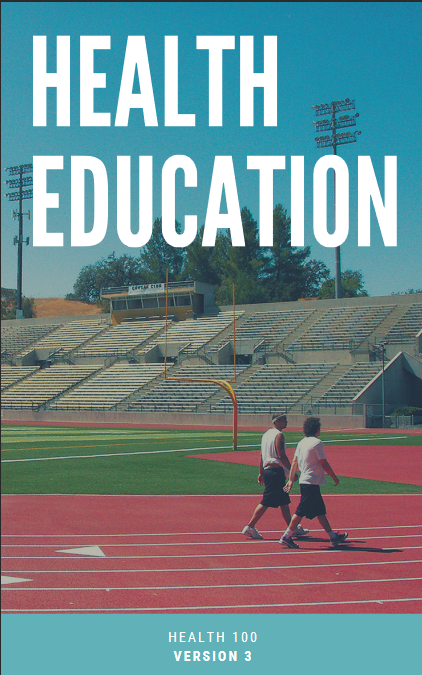

In [26]:
final_app

In [27]:
# this command will launch the final app in a new tab (for debugging purposes)
final_app.show()

Row
    [0] HSpacer()
    [1] Column
        [0] Row
            [0] HSpacer()
            [1] Markdown(str, style={'font-family': 'impact'})
            [2] HSpacer()
        [1] Markdown(str, style={'font-family': ''})
        [2] PNG(str, align='center', height=300)
        [3] Column
            [0] Column
                [0] Select(name='Try a Sample Question:', options=['', 'What is health?', ...])
                [1] TextInput(name='Or enter your o..., placeholder='Input a Health E...)
                [2] Button(button_type='warning', name='Submit')
                [3] Markdown(str)
                [4] Markdown(str)
                [5] Markdown(str, background='yellow', width=600)
        [4] HTML(str, align='center')
    [2] HSpacer()
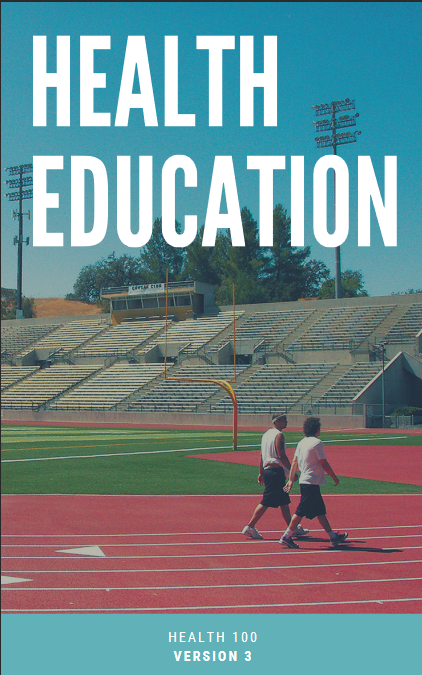

In [28]:
#export
# this command is needed in order to serve this app in production mode. (make sure to uncomment ofcourse)
final_app.servable()

In [29]:
# bash command to serve this app in a production setting
# ! panel serve --show "TextbookQA_App.ipynb"

In [30]:
! python scripts/notebook2script.py notebooks/"Askai App.ipynb"

Converted notebooks/Askai App.ipynb to askai_app.py
